# HW07: Deep Learning (due 16th November)

In this homework, you will replicate the heterogenous treatment effect exercise from last week's homework using a deep learning model instead of a machine learning one. 

For those who did not complete this exercise, you will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to *intensive* or *standard* case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group.

We will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management. 

In [1]:
import pandas as pd
from tensorflow import keras

In [2]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta', iterator=True).variable_labels()

{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [3]:
df.head()

,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.

In [4]:
treatvar = 'rand'
df[treatvar].value_counts()

Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [5]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()

,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model.

In [6]:
#Encoding Categorical covariates and preparing the data for tensorflow
covariates = ['status', 'sex', 'sat94', 'ocfabth', 'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()

,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [7]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

df_treat = df.loc[df[treatvar]=='Intensive case management']
df_control = df.loc[df[treatvar]!='Intensive case management']

from sklearn.model_selection import train_test_split
Xt_train, Xt_test, yt_train, yt_test = train_test_split(df_treat[covariates], df_treat['hos96'], test_size=0.3)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(df_control[covariates], df_control['hos96'], test_size=0.3)

In [8]:
Xt_train.shape

(91, 9)

In [9]:
##choose one of the three outcomes to analyze
## build two MLP (multilayer perceptron) models to predict the outcome based on the covariates
## the first model should be trained on the treated sample, while the second on the control

# the two MLP models should have with at least 2 hidden layers, ReLU activation, batch normalization, dropout

model_treat = keras.models.Sequential()
model_control = keras.models.Sequential()

model_treat.add(keras.layers.Dense(30, input_dim = Xt_train.shape[1], activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(0.3))
model_treat.add(keras.layers.Dense(30, activation="relu"))
model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(0.3))
model_treat.add(keras.layers.Dense(15, activation="relu"))
#model_treat.add(keras.layers.BatchNormalization())
model_treat.add(keras.layers.Dropout(0.3))
model_treat.add(keras.layers.Dense(1))

model_treat.summary()


model_control.add(keras.layers.Dense(30, input_dim = Xc_train.shape[1], activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(0.5))
model_control.add(keras.layers.Dense(30, activation="relu"))
model_control.add(keras.layers.BatchNormalization())
model_control.add(keras.layers.Dropout(0.5))
model_control.add(keras.layers.Dense(15, activation="relu"))
#model_control.add(keras.layers.BatchNormalization()) # Bathcnorm in the last layer causes very bad results
model_control.add(keras.layers.Dropout(0.5))
model_control.add(keras.layers.Dense(1))

model_control.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                300       
                                                                 
 batch_normalization (BatchN  (None, 30)               120       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_1 (Dense)             (None, 30)                930       
                                                                 
 batch_normalization_1 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 30)                0

In [10]:
# compile the models
model_treat.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])
model_control.compile(loss="mean_squared_error",
              optimizer="adam",
              metrics=["mean_squared_error"])

In [11]:
# fit separate models on the treatment dataset and control dataset
# use early stopping
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)

history_treat = model_treat.fit(Xt_train, yt_train, epochs=1000,
                    validation_split=0.2, callbacks = [es])
history_control = model_control.fit(Xc_train, yc_train, epochs=1000,
                    validation_split=0.2, callbacks = [es])

Epoch 1/1000


C:\Users\joppe\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


3/3 [==============================] - 1s 106ms/step - loss: 18590.2578 - mean_squared_error: 18590.2578 - val_loss: 19532.9492 - val_mean_squared_error: 19532.9492
Epoch 2/1000
3/3 [==============================] - 0s 30ms/step - loss: 18584.6934 - mean_squared_error: 18584.6934 - val_loss: 19267.6797 - val_mean_squared_error: 19267.6797
Epoch 3/1000
3/3 [==============================] - 0s 16ms/step - loss: 18550.9121 - mean_squared_error: 18550.9121 - val_loss: 19111.4941 - val_mean_squared_error: 19111.4941
Epoch 4/1000
3/3 [==============================] - 0s 17ms/step - loss: 18647.3262 - mean_squared_error: 18647.3262 - val_loss: 18995.9219 - val_mean_squared_error: 18995.9219
Epoch 5/1000
3/3 [==============================] - 0s 18ms/step - loss: 18600.3945 - mean_squared_error: 18600.3945 - val_loss: 18921.5039 - val_mean_squared_error: 18921.5039
Epoch 6/1000
3/3 [==============================] - 0s 17ms/step - loss: 18461.4609 - mean_squared_error: 18461.4609 - val_loss

3/3 [==============================] - 0s 15ms/step - loss: 18005.6914 - mean_squared_error: 18005.6914 - val_loss: 18216.4062 - val_mean_squared_error: 18216.4062
Epoch 48/1000
3/3 [==============================] - 0s 15ms/step - loss: 17979.7676 - mean_squared_error: 17979.7676 - val_loss: 18202.8379 - val_mean_squared_error: 18202.8379
Epoch 49/1000
3/3 [==============================] - 0s 15ms/step - loss: 18045.6992 - mean_squared_error: 18045.6992 - val_loss: 18193.7871 - val_mean_squared_error: 18193.7871
Epoch 50/1000
3/3 [==============================] - 0s 14ms/step - loss: 17935.8828 - mean_squared_error: 17935.8828 - val_loss: 18181.3496 - val_mean_squared_error: 18181.3496
Epoch 51/1000
3/3 [==============================] - 0s 15ms/step - loss: 17883.8672 - mean_squared_error: 17883.8672 - val_loss: 18166.3379 - val_mean_squared_error: 18166.3379
Epoch 52/1000
3/3 [==============================] - 0s 15ms/step - loss: 17862.0957 - mean_squared_error: 17862.0957 - val_

3/3 [==============================] - 0s 16ms/step - loss: 16477.4473 - mean_squared_error: 16477.4473 - val_loss: 16972.8457 - val_mean_squared_error: 16972.8457
Epoch 94/1000
3/3 [==============================] - 0s 16ms/step - loss: 16195.7070 - mean_squared_error: 16195.7070 - val_loss: 16930.5469 - val_mean_squared_error: 16930.5469
Epoch 95/1000
3/3 [==============================] - 0s 15ms/step - loss: 16579.8730 - mean_squared_error: 16579.8730 - val_loss: 16890.7344 - val_mean_squared_error: 16890.7344
Epoch 96/1000
3/3 [==============================] - 0s 16ms/step - loss: 16409.6484 - mean_squared_error: 16409.6484 - val_loss: 16844.0547 - val_mean_squared_error: 16844.0547
Epoch 97/1000
3/3 [==============================] - 0s 18ms/step - loss: 16463.6055 - mean_squared_error: 16463.6055 - val_loss: 16803.7559 - val_mean_squared_error: 16803.7559
Epoch 98/1000
3/3 [==============================] - 0s 28ms/step - loss: 15690.3320 - mean_squared_error: 15690.3320 - val_

Epoch 139/1000
3/3 [==============================] - 0s 15ms/step - loss: 12829.2588 - mean_squared_error: 12829.2588 - val_loss: 14600.7881 - val_mean_squared_error: 14600.7881
Epoch 140/1000
3/3 [==============================] - 0s 15ms/step - loss: 12876.7881 - mean_squared_error: 12876.7881 - val_loss: 14571.6562 - val_mean_squared_error: 14571.6562
Epoch 141/1000
3/3 [==============================] - 0s 16ms/step - loss: 13795.0898 - mean_squared_error: 13795.0898 - val_loss: 14527.7041 - val_mean_squared_error: 14527.7041
Epoch 142/1000
3/3 [==============================] - 0s 15ms/step - loss: 13003.2383 - mean_squared_error: 13003.2383 - val_loss: 14502.8467 - val_mean_squared_error: 14502.8467
Epoch 143/1000
3/3 [==============================] - 0s 16ms/step - loss: 14503.7070 - mean_squared_error: 14503.7070 - val_loss: 14515.5859 - val_mean_squared_error: 14515.5859
Epoch 144/1000
3/3 [==============================] - 0s 16ms/step - loss: 12622.7607 - mean_squared_erro

C:\Users\joppe\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


2/2 [==============================] - 1s 176ms/step - loss: 15027.0645 - mean_squared_error: 15027.0645 - val_loss: 12215.8242 - val_mean_squared_error: 12215.8242
Epoch 2/1000
2/2 [==============================] - 0s 38ms/step - loss: 15024.9404 - mean_squared_error: 15024.9404 - val_loss: 12111.3213 - val_mean_squared_error: 12111.3213
Epoch 3/1000
2/2 [==============================] - 0s 33ms/step - loss: 15030.5859 - mean_squared_error: 15030.5859 - val_loss: 12057.2734 - val_mean_squared_error: 12057.2734
Epoch 4/1000
2/2 [==============================] - 0s 32ms/step - loss: 15187.6045 - mean_squared_error: 15187.6045 - val_loss: 12016.9150 - val_mean_squared_error: 12016.9150
Epoch 5/1000
2/2 [==============================] - 0s 30ms/step - loss: 15030.1094 - mean_squared_error: 15030.1094 - val_loss: 11986.4336 - val_mean_squared_error: 11986.4336
Epoch 6/1000
2/2 [==============================] - 0s 30ms/step - loss: 15009.6211 - mean_squared_error: 15009.6211 - val_loss

2/2 [==============================] - 0s 28ms/step - loss: 14860.0664 - mean_squared_error: 14860.0664 - val_loss: 11694.5664 - val_mean_squared_error: 11694.5664
Epoch 48/1000
2/2 [==============================] - 0s 29ms/step - loss: 14822.2930 - mean_squared_error: 14822.2930 - val_loss: 11687.7734 - val_mean_squared_error: 11687.7734
Epoch 49/1000
2/2 [==============================] - 0s 28ms/step - loss: 14838.5000 - mean_squared_error: 14838.5000 - val_loss: 11680.8281 - val_mean_squared_error: 11680.8281
Epoch 50/1000
2/2 [==============================] - 0s 28ms/step - loss: 14917.5098 - mean_squared_error: 14917.5098 - val_loss: 11673.1797 - val_mean_squared_error: 11673.1797
Epoch 51/1000
2/2 [==============================] - 0s 27ms/step - loss: 14839.3516 - mean_squared_error: 14839.3516 - val_loss: 11665.6465 - val_mean_squared_error: 11665.6465
Epoch 52/1000
2/2 [==============================] - 0s 28ms/step - loss: 14717.9316 - mean_squared_error: 14717.9316 - val_

2/2 [==============================] - 0s 33ms/step - loss: 14368.1094 - mean_squared_error: 14368.1094 - val_loss: 11300.0059 - val_mean_squared_error: 11300.0059
Epoch 94/1000
2/2 [==============================] - 0s 32ms/step - loss: 14315.9121 - mean_squared_error: 14315.9121 - val_loss: 11288.9941 - val_mean_squared_error: 11288.9941
Epoch 95/1000
2/2 [==============================] - 0s 30ms/step - loss: 14434.6475 - mean_squared_error: 14434.6475 - val_loss: 11277.1533 - val_mean_squared_error: 11277.1533
Epoch 96/1000
2/2 [==============================] - 0s 33ms/step - loss: 14327.8496 - mean_squared_error: 14327.8496 - val_loss: 11265.0508 - val_mean_squared_error: 11265.0508
Epoch 97/1000
2/2 [==============================] - 0s 30ms/step - loss: 14432.5586 - mean_squared_error: 14432.5586 - val_loss: 11252.3672 - val_mean_squared_error: 11252.3672
Epoch 98/1000
2/2 [==============================] - 0s 29ms/step - loss: 14514.4756 - mean_squared_error: 14514.4756 - val_

Epoch 139/1000
2/2 [==============================] - 0s 28ms/step - loss: 13346.5615 - mean_squared_error: 13346.5615 - val_loss: 10443.6387 - val_mean_squared_error: 10443.6387
Epoch 140/1000
2/2 [==============================] - 0s 29ms/step - loss: 13335.0205 - mean_squared_error: 13335.0205 - val_loss: 10416.6279 - val_mean_squared_error: 10416.6279
Epoch 141/1000
2/2 [==============================] - 0s 27ms/step - loss: 13148.8291 - mean_squared_error: 13148.8291 - val_loss: 10389.5010 - val_mean_squared_error: 10389.5010
Epoch 142/1000
2/2 [==============================] - 0s 32ms/step - loss: 13678.5908 - mean_squared_error: 13678.5908 - val_loss: 10361.9814 - val_mean_squared_error: 10361.9814
Epoch 143/1000
2/2 [==============================] - 0s 33ms/step - loss: 13595.6846 - mean_squared_error: 13595.6846 - val_loss: 10335.3623 - val_mean_squared_error: 10335.3623
Epoch 144/1000
2/2 [==============================] - 0s 30ms/step - loss: 14081.3906 - mean_squared_erro

2/2 [==============================] - 0s 26ms/step - loss: 11645.2578 - mean_squared_error: 11645.2578 - val_loss: 9155.4053 - val_mean_squared_error: 9155.4053
Epoch 186/1000
2/2 [==============================] - 0s 27ms/step - loss: 11666.2441 - mean_squared_error: 11666.2441 - val_loss: 9124.4736 - val_mean_squared_error: 9124.4736
Epoch 187/1000
2/2 [==============================] - 0s 30ms/step - loss: 12013.9844 - mean_squared_error: 12013.9844 - val_loss: 9099.0098 - val_mean_squared_error: 9099.0098
Epoch 188/1000
2/2 [==============================] - 0s 30ms/step - loss: 11568.1738 - mean_squared_error: 11568.1738 - val_loss: 9074.7705 - val_mean_squared_error: 9074.7705
Epoch 189/1000
2/2 [==============================] - 0s 29ms/step - loss: 11307.9785 - mean_squared_error: 11307.9785 - val_loss: 9047.1992 - val_mean_squared_error: 9047.1992
Epoch 190/1000
2/2 [==============================] - 0s 31ms/step - loss: 13175.2441 - mean_squared_error: 13175.2441 - val_loss:

2/2 [==============================] - 0s 28ms/step - loss: 12330.7441 - mean_squared_error: 12330.7441 - val_loss: 8352.5049 - val_mean_squared_error: 8352.5049
Epoch 232/1000
2/2 [==============================] - 0s 29ms/step - loss: 11259.0059 - mean_squared_error: 11259.0059 - val_loss: 8371.1719 - val_mean_squared_error: 8371.1719
Epoch 233/1000
2/2 [==============================] - 0s 27ms/step - loss: 12578.9004 - mean_squared_error: 12578.9004 - val_loss: 8396.8760 - val_mean_squared_error: 8396.8760
Epoch 234/1000
2/2 [==============================] - 0s 25ms/step - loss: 9497.8486 - mean_squared_error: 9497.8486 - val_loss: 8411.2402 - val_mean_squared_error: 8411.2402
Epoch 235/1000
2/2 [==============================] - 0s 26ms/step - loss: 12283.7266 - mean_squared_error: 12283.7266 - val_loss: 8414.4824 - val_mean_squared_error: 8414.4824
Epoch 236/1000
2/2 [==============================] - 0s 27ms/step - loss: 9992.7207 - mean_squared_error: 9992.7207 - val_loss: 840

2/2 [==============================] - 0s 33ms/step - loss: 10715.0918 - mean_squared_error: 10715.0918 - val_loss: 7906.7510 - val_mean_squared_error: 7906.7510
Epoch 278/1000
2/2 [==============================] - 0s 33ms/step - loss: 10789.9805 - mean_squared_error: 10789.9805 - val_loss: 7903.8750 - val_mean_squared_error: 7903.8750
Epoch 279/1000
2/2 [==============================] - 0s 32ms/step - loss: 8978.3418 - mean_squared_error: 8978.3418 - val_loss: 7901.8179 - val_mean_squared_error: 7901.8179
Epoch 280/1000
2/2 [==============================] - 0s 33ms/step - loss: 9121.7812 - mean_squared_error: 9121.7812 - val_loss: 7908.6436 - val_mean_squared_error: 7908.6436
Epoch 281/1000
2/2 [==============================] - 0s 32ms/step - loss: 10770.2070 - mean_squared_error: 10770.2070 - val_loss: 7938.3711 - val_mean_squared_error: 7938.3711
Epoch 281: early stopping


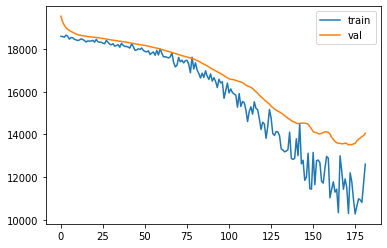

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot performance by epoch
plt.plot(history_treat.epoch,history_treat.history['mean_squared_error'])
plt.plot(history_treat.epoch,history_treat.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')

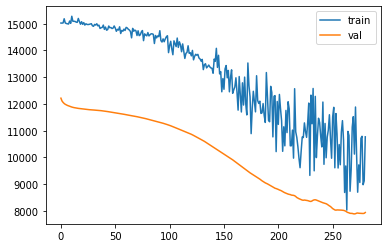

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
# Plot performance by epoch
plt.plot(history_control.epoch,history_control.history['mean_squared_error'])
plt.plot(history_control.epoch,history_control.history['val_mean_squared_error'])
plt.legend(['train', 'val'], loc='best')

In [14]:
##get predicted outcomes using the combined test sets for both models 

test_set = Xt_test.append(Xc_test) 
yhat_treat = model_treat.predict(test_set)
yhat_control = model_control.predict(test_set)

3/3 [==============================] - 0s 2ms/step


C:\Users\joppe\AppData\Local\Temp/ipykernel_16608/184693369.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_set = Xt_test.append(Xc_test)


3/3 [==============================] - 0s 1ms/step


In [15]:
##find the three individuals in the test set that are most and least responsive to the treatment
##namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = yhat_treat - yhat_control

test_set = test_set.sort_values('treat_effect', axis=0)
most_least_treat = test_set[:3].append(test_set[-3:])
most_least_treat

C:\Users\joppe\AppData\Local\Temp/ipykernel_16608/3987331780.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  most_least_treat = test_set[:3].append(test_set[-3:])


,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,treat_effect
195,1.0,0.0,12.375,4.0,126.0,0.500000,4.0,38.0,0.0,-58.062054
335,0.0,1.0,15.000,0.0,180.0,0.285714,9.0,45.0,1.0,-55.549210
8,0.0,0.0,14.000,3.0,238.0,0.600000,1.0,34.0,1.0,-50.796448
276,1.0,1.0,22.000,4.0,420.0,1.428571,32.0,47.0,1.0,61.455837
27,0.0,1.0,26.000,3.0,35.0,2.166666,26.0,40.0,1.0,68.166328
151,1.0,1.0,24.000,3.0,558.0,2.000000,40.0,33.0,1.0,130.629913


<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

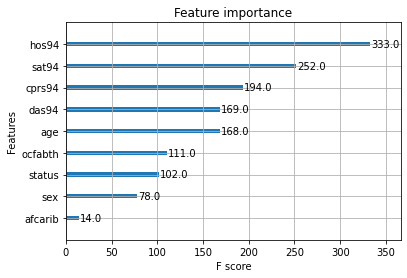

In [16]:
##visualize and comment on the covariates of these individuals 
from xgboost import plot_importance, XGBRegressor
xgb = XGBRegressor()
xgb.fit(test_set[covariates], test_set['treat_effect'])

plot_importance(xgb)